<a href="https://colab.research.google.com/github/shubhamsks/deep-learning/blob/master/FlowerClassifier_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg

Cloning into 'tensorflow_vgg'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (113/113), 56.40 KiB | 5.64 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',#udacity url for pretrained weights
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [00:12, 45.3MB/s]                           


In [3]:
# getting the flower dataset 
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

Flowers Dataset: 229MB [00:03, 66.8MB/s]                           


In [0]:
# preprocessing our dataset 
# Taking all the images of the dataset and getting the code for each of them
import os
import tensorflow as tf
from  tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [0]:
data_dir = 'flower_photos/' #data that we downloaded above 
contents = os.listdir(data_dir)
classes = [class_name for class_name in contents if os.path.isdir(data_dir + class_name)] #getting the class of different flowers

In [5]:

# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/content/tensorflow_vgg/vgg16.npy


W0819 18:18:14.657155 140339494766464 deprecation_wrapper.py:119] From /content/tensorflow_vgg/vgg16.py:90: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0819 18:18:14.669405 140339494766464 deprecation_wrapper.py:119] From /content/tensorflow_vgg/vgg16.py:87: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



npy file loaded
build model started
build model finished: 1s
Starting sunflowers images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
420 images processed
430 images processed
440 images process

In [0]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [0]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [8]:
labels.shape

(3670,)

In [0]:
# Preprocessing the labels (one hot encoding)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(labels)
labels_vecs = lb.transform(labels)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

In [0]:
half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [12]:
print('Train shapes (x, y) ',train_x.shape, train_y.shape)
print('Validation shapes(x, y) ',val_x.shape, val_y.shape)
print('Test shapes (x, y ) ',test_x.shape, test_y.shape)

Train shapes (x, y)  (2936, 4096) (2936, 5)
Validation shapes(x, y)  (367, 4096) (367, 5)
Test shapes (x, y )  (367, 4096) (367, 5)


In [13]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

W0819 18:23:25.330814 140339494766464 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0819 18:23:25.777909 140339494766464 deprecation.py:323] From <ipython-input-13-9974f297d78b>:7: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [15]:
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 10.61254
Epoch: 1/10 Iteration: 1 Training loss: 21.31663
Epoch: 1/10 Iteration: 2 Training loss: 22.21582
Epoch: 1/10 Iteration: 3 Training loss: 14.87845
Epoch: 1/10 Iteration: 4 Training loss: 6.43992
Epoch: 0/10 Iteration: 5 Validation Acc: 0.5995
Epoch: 1/10 Iteration: 5 Training loss: 4.52980
Epoch: 1/10 Iteration: 6 Training loss: 3.85411
Epoch: 1/10 Iteration: 7 Training loss: 2.03420
Epoch: 1/10 Iteration: 8 Training loss: 3.20964
Epoch: 1/10 Iteration: 9 Training loss: 2.75540
Epoch: 0/10 Iteration: 10 Validation Acc: 0.5940
Epoch: 2/10 Iteration: 10 Training loss: 3.12011
Epoch: 2/10 Iteration: 11 Training loss: 2.25866
Epoch: 2/10 Iteration: 12 Training loss: 2.25774
Epoch: 2/10 Iteration: 13 Training loss: 1.38122
Epoch: 2/10 Iteration: 14 Training loss: 1.11349
Epoch: 1/10 Iteration: 15 Validation Acc: 0.8311
Epoch: 2/10 Iteration: 15 Training loss: 0.82920
Epoch: 2/10 Iteration: 16 Training loss: 0.99671
Epoch: 2/10 Iteration: 17 T

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

W0819 18:28:10.014432 140339494766464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test accuracy: 0.8856


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2

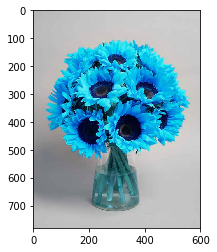

In [32]:
test_img_path = 'yellow.jpeg'
test_img = cv2.imread(test_img_path)
plt.imshow(test_img,cmap='BrBG')

In [33]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/content/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s


In [0]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

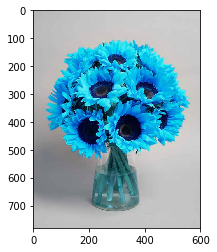

In [35]:
plt.imshow(test_img)

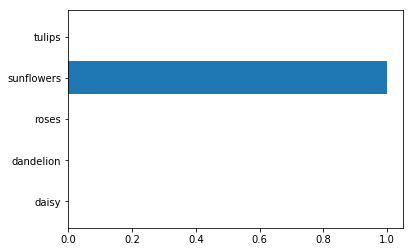

In [36]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)